In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
import faiss

In [1]:
# Load model directly
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("posicube/Llama2-chat-AYT-13B")

In [4]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [5]:
with open("vocab.txt", "w") as file:
    file.write(str(tokenizer.vocab))

In [6]:
inputs = ["it has been said that cheese is good for the body", "hi there"]

In [7]:
llamaOutputs = tokenizer(inputs, padding="longest")
llamaOutputs['input_ids'][0]

[1, 372, 756, 1063, 1497, 393, 923, 968, 338, 1781, 363, 278, 3573]

In [8]:
# so now we know how to use tokenizers
# we can use faiss to compare tokenizers

In [2]:
bertTokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [59]:
bertTokenizer.add_special_tokens({"pad_token":"[PAD]"})

0

In [10]:
open("bertVocab.txt", "w").write(str(bertTokenizer.vocab))

522321

In [11]:
bertOutputs = bertTokenizer(inputs, padding="longest")
bertOutputs["input_ids"][0]

[101, 2009, 2038, 2042, 2056, 2008, 8808, 2003, 2204, 2005, 1996, 2303, 102]

In [12]:
len(bertOutputs['input_ids'][0])

13

In [13]:
len(llamaOutputs['input_ids'][0])

13

In [14]:
index = faiss.IndexFlatL2(13)

In [15]:
index.is_trained

True

In [16]:
import numpy as np

In [17]:
index.add(np.array([bertOutputs['input_ids'][0], llamaOutputs['input_ids'][0]], dtype=np.float32))

In [18]:
index.ntotal

2

In [3]:
from transformers import AutoModelForMaskedLM

bertModel = AutoModelForMaskedLM.from_pretrained("bert-base-uncased").cpu()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
bertModel.base_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [5]:
bertEmbeddings = bertModel.get_input_embeddings()

In [6]:
bertEmbeddings

Embedding(30522, 768, padding_idx=0)

In [7]:
bertEmbeddings.cpu()

Embedding(30522, 768, padding_idx=0)

## Playing around with pipelines

In [8]:
encodedInput = bertTokenizer("hi there, I would like to order a [MASK] please", return_tensors="pt")

In [9]:
for item in encodedInput:
    encodedInput[item].cpu()

In [10]:
output = bertModel(**encodedInput)
output

MaskedLMOutput(loss=None, logits=tensor([[[ -6.8868,  -6.8263,  -6.8384,  ...,  -6.1582,  -6.0658,  -4.1332],
         [ -9.0659,  -9.1499,  -9.4144,  ...,  -8.8747,  -8.6684,  -7.9443],
         [ -8.8072,  -8.6691,  -9.0157,  ...,  -6.5108,  -9.4665,  -7.6807],
         ...,
         [ -6.2883,  -6.2995,  -6.2399,  ...,  -5.8153,  -5.8282,  -7.1735],
         [ -9.1955,  -8.7199,  -9.0054,  ...,  -8.0317,  -9.5727,  -4.0663],
         [-12.7245, -12.4730, -12.4347,  ..., -10.1119, -11.0987,  -9.5461]]],
       grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)

In [11]:
from transformers import pipeline

In [12]:
pipe = pipeline("fill-mask", model=bertModel, tokenizer=bertTokenizer)

In [13]:
pipe("hi there, I would like to order a [MASK] please")

[{'score': 0.45235180854797363,
  'token': 10733,
  'token_str': 'pizza',
  'sequence': 'hi there, i would like to order a pizza please'},
 {'score': 0.08983268588781357,
  'token': 4157,
  'token_str': 'coffee',
  'sequence': 'hi there, i would like to order a coffee please'},
 {'score': 0.08926834911108017,
  'token': 4392,
  'token_str': 'drink',
  'sequence': 'hi there, i would like to order a drink please'},
 {'score': 0.04524002969264984,
  'token': 5404,
  'token_str': 'beer',
  'sequence': 'hi there, i would like to order a beer please'},
 {'score': 0.028834141790866852,
  'token': 11642,
  'token_str': 'sandwich',
  'sequence': 'hi there, i would like to order a sandwich please'}]

In [14]:
import torch

In [15]:
# 10 since that's the index of 103 (the [MASK] token)
temp = torch.softmax(output.logits[0, 10], 0)

In [16]:
highest_prob = torch.argmax(temp)
print("highest prob occurs at", highest_prob, "and is", temp[highest_prob])
print("this is the word", bertTokenizer.decode(highest_prob))

highest prob occurs at tensor(10733) and is tensor(0.4524, grad_fn=<SelectBackward0>)
this is the word pizza


## Actually Using Embeddings

In [57]:
help(bertEmbeddings.forward)

Help on method forward in module torch.nn.modules.sparse:

forward(input: torch.Tensor) -> torch.Tensor method of torch.nn.modules.sparse.Embedding instance
    Defines the computation performed at every call.
    
    Should be overridden by all subclasses.
    
    .. note::
        Although the recipe for forward pass needs to be defined within
        this function, one should call the :class:`Module` instance afterwards
        instead of this since the former takes care of running the
        registered hooks while the latter silently ignores them.



In [1]:
bertTokenizer("hi there")
{"input_ids": [12332, 5432334]}

NameError: name 'bertTokenizer' is not defined

In [17]:
bertEmbeddingsOutput = bertEmbeddings(encodedInput['input_ids'])

In [18]:
bertEmbeddingsOutput

tensor([[[ 0.0136, -0.0265, -0.0235,  ...,  0.0087,  0.0071,  0.0151],
         [-0.0138, -0.0868,  0.0433,  ..., -0.0652, -0.1024, -0.0509],
         [-0.0749,  0.0071, -0.0074,  ...,  0.0114,  0.0323,  0.0041],
         ...,
         [ 0.0037, -0.0069,  0.0087,  ...,  0.0054, -0.0043, -0.0004],
         [-0.0479, -0.0136, -0.0444,  ...,  0.0245, -0.0535, -0.0050],
         [-0.0145, -0.0100,  0.0060,  ..., -0.0250,  0.0046, -0.0015]]],
       grad_fn=<EmbeddingBackward0>)

In [19]:
bertEmbeddingsOutput.shape

torch.Size([1, 13, 768])

## Visualize

In [20]:
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

In [21]:
tsne = TSNE(perplexity=2,learning_rate=50)

In [22]:
npBertEmbeddings = bertEmbeddingsOutput.detach().numpy()

In [23]:
npBertEmbeddings.shape

(1, 13, 768)

In [24]:
npBertEmbeddings = npBertEmbeddings[0]

In [25]:
tsne_features = tsne.fit_transform(npBertEmbeddings)

In [26]:
tsne_features.shape

(13, 2)

/home/eliot/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/eliot/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: >

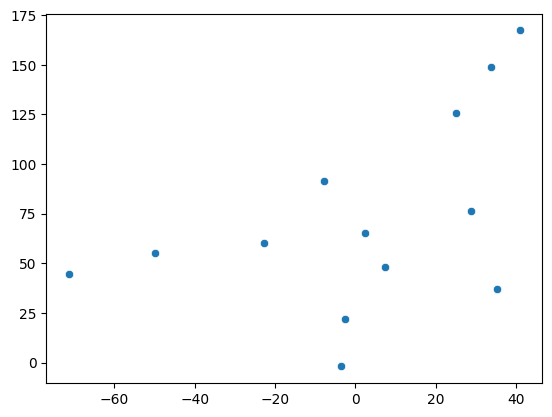

In [27]:
sns.scatterplot(x=tsne_features[:,0], y=tsne_features[:,1])

## Set Up Tensorboard

In [28]:
from torch.utils.tensorboard import SummaryWriter

In [29]:
writer = SummaryWriter("experiment")

## Add embeddings projector

In [30]:
import datasets

In [31]:
imdb = datasets.load_dataset("imdb")

In [114]:
def embed(tokenizer:AutoTokenizer, embedder, dataset: datasets.Dataset, num_samples:int = 200):
    encodedInputs = tokenizer(dataset['text'][:num_samples], padding=True, truncation=True, max_length=300, return_tensors='pt')
    embedder.cpu()
    embeddedOutputs = embedder(encodedInputs.input_ids)
    return embeddedOutputs, tokenizer.batch_decode(encodedInputs.input_ids)

def embed_words(tokenizer:AutoTokenizer, embedder, num_samples:int = None):
    if num_samples:
        temp = list(tokenizer.vocab.keys())
        out_labels = []
        for idx in torch.randperm(len(tokenizer.vocab))[:num_samples]:
            out_labels.append(temp[idx])
    else:
        out_labels = list(tokenizer.vocab.keys())

    # batch encode
    encodedInputs = tokenizer(out_labels, return_tensors="pt", max_length=3, truncation=True, padding=True)
    embeddedOutputs = embedder(encodedInputs.input_ids)
    return embeddedOutputs[:, 1], tokenizer.batch_decode(encodedInputs.input_ids)

In [116]:
embeddings, labels = embed_words(bertTokenizer, bertEmbeddings)

In [54]:
imdb['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [55]:
imdb['train']['label'][0]

0

In [66]:
embeddedOutputs = bertEmbeddings(bertTokenizer(imdb['train']['text'][0], padding=True, truncation=True, max_length=300, return_tensors='pt').input_ids)

In [69]:
bertTokenizer.batch_decode(bertTokenizer(imdb['train']['text'][0], padding=True, truncation=True, max_length=300, return_tensors='pt').input_ids)

['[CLS] i rented i am curious - yellow from my video store because of all the controversy that surrounded it when it was first released in 1967. i also heard that at first it was seized by u. s. customs if it ever tried to enter this country, therefore being a fan of films considered " controversial " i really had to see this for myself. < br / > < br / > the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life. in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states. in between asking politicians and ordinary denizens of stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men. < br / > < br / > what kills me about i am curious - yellow is that 40 years ago, this was considered pornographic. really, the sex and nudity scenes

In [67]:
embeddedOutputs

tensor([[[ 0.0136, -0.0265, -0.0235,  ...,  0.0087,  0.0071,  0.0151],
         [-0.0211,  0.0059, -0.0179,  ...,  0.0163,  0.0122,  0.0073],
         [-0.1213, -0.0676, -0.0739,  ..., -0.0375, -0.0381,  0.0286],
         ...,
         [ 0.0276, -0.0093, -0.0574,  ...,  0.0169,  0.0165, -0.0313],
         [-0.0360, -0.0246, -0.0257,  ...,  0.0034, -0.0018,  0.0269],
         [-0.0145, -0.0100,  0.0060,  ..., -0.0250,  0.0046, -0.0015]]],
       grad_fn=<EmbeddingBackward0>)

In [44]:
embeddings = embeddings.reshape(embeddings.shape[0], -1)

In [47]:
writer.close()

In [50]:
writer.add_graph(bertEmbeddings, input_to_model=encodedInput.input_ids)
writer.close()

## LLama thing

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import accelerate

tokenizer = AutoTokenizer.from_pretrained("converted-llama", fp16=True)

model = AutoModelForCausalLM.from_pretrained("converted-llama", load_in_4bit=True, device_map="auto")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
tokenizer.add_special_tokens({"pad_token":"[PAD]", "mask_token":"[MASK]"})

2

In [37]:
encoded = tokenizer("""
There's a llama in my garden 😱 What should I do?
""", return_tensors="pt")
encoded

{'input_ids': tensor([[    1, 29871,    13,  8439, 29915, 29879,   263, 11148,  3304,   297,
           590, 16423, 29871,   243,   162,   155,   180,  1724,   881,   306,
           437, 29973,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [38]:
encoded['input_ids'].shape

torch.Size([1, 23])

In [39]:
output = model.generate(encoded.input_ids, max_length=encoded.input_ids.shape[-1] + 50)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [40]:
output

tensor([[    1, 29871,    13,  8439, 29915, 29879,   263, 11148,  3304,   297,
           590, 16423, 29871,   243,   162,   155,   180,  1724,   881,   306,
           437, 29973,    13, 30003, 29992, 29933,  5371, 29934, 29946,    13,
         29902, 29915, 29885,   451,  1854,   825,   304,   437, 29889,   306,
         29915,   345,  2360,   750,   263, 11148,  3304,   297,   590, 16423,
          1434, 29889,    13, 30003, 29992, 29933,  5371, 29934, 29946,    13,
         29902, 29915, 29885,   451,  1854,   825,   304,   437, 29889,   306,
         29915,   345,  2360]])

In [41]:
tokenizer.batch_decode(output)

["<s> \nThere's a llama in my garden 😱 What should I do?\n—@BBCR4\nI'm not sure what to do. I've never had a llama in my garden before.\n—@BBCR4\nI'm not sure what to do. I've never"]